In [20]:
%load_ext autoreload
%autoreload 2
import torch as t
import cv2 
from model import EfficientnetWithFinetuning
from data import MelanomaData
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, f1_score, accuracy_score
from sklearn.decomposition import PCA
import random 
import pandas as pd
import seaborn as sns

plt.style.use('dark_background')
os.environ["CUDA_VISIBLE_DEVICES"]="1"

os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/data_nfs/je30bery/melanoma_data/model'

In [2]:
markers = ['ADAM10', 'Bcl-2', 'CD10', 'CD107a', 'CD13', 'CD138', 'CD14', 'CD1a', 'CD2', 'CD25', 'CD271', 'CD3', 'CD36', 'CD4', 'CD44', 'CD45', 'CD45RA', 'CD45RO', 'CD5', 'CD56', 'CD6', 'CD63', 'CD66abce', 'CD7', 'CD71', 'CD8', 'CD9', 'CD95', 'Collagen IV', 'Cytokeratin-14', 'EBF-P', 'EGFR', 'EGFR-AF488', 'HLA-ABC', 'HLA-DR', 'KIP1', 'Ki67', 'L302', 'MCSP', 'Melan-A', 'Nestin-AF488', 'Notch-1', 'Notch-3', 'PPARgamma', 'PPB', 'RIM3', 'TAP73', 'Vimentin', 'p63', 'phospho-Connexin']    

In [3]:
data = "/data_nfs/datasets/melc/melanoma/processed"
vdata = [os.path.join(data, "validation", d) for d in sorted(os.listdir(os.path.join(data, "validation")))] # balance_and_shuffle(os.path.join(data, "validation"))#
tdata = [os.path.join(data, "training", d) for d in sorted(os.listdir(os.path.join(data, "training")))] # balance_and_shuffle(os.path.join(data, "validation"))#
data = vdata + tdata
dl = t.utils.data.DataLoader(MelanomaData(markers, data, mode="val"), batch_size=10) #, shuffle=True)

In [4]:
model = EfficientnetWithFinetuning(indim=len(markers))
model.load_state_dict(t.load("/data_nfs/je30bery/melanoma_data/model/saved_models/model_2023-11-20 16:27:56.558630_f1=0.9260606060606061_acc=0.9166666666666666_11.pt"))
model.eval()

EfficientnetWithFinetuning(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(50, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): 

In [5]:
labels = np.array([int("Nevi" in d) for d in data])
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [6]:
def extract_features(model, x):
    model = model.cuda()
    x = x.cuda()
    x = model.features(x)
    x = model.avgpool(x)
    x = model.flatten(x)
    x = model.classifier1(x)    
    return x

In [7]:
it = iter(dl)

In [8]:
features = list()
while True:
    try:
        input_t, label = next(it)
    except StopIteration:
        break
    features.append(extract_features(model, input_t).detach().cpu().numpy())

In [9]:
features = np.concatenate(features)
features.shape

(197, 50)

In [64]:
num_pertubations = 1000
shilouette_scores = list()
reference_scores = list()

mel_features = features[np.where(labels==0)]

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, n_init="auto")
    y = kmeans.fit_predict(mel_features)
    y_copy = y.copy()
    score = silhouette_score(mel_features, y)
    shilouette_scores.append(score)

    acc = list()
    for j in range(num_pertubations):
        random.shuffle(y)
        acc.append(silhouette_score(mel_features, y))
    reference_scores.append(score - np.array(acc))

In [65]:
gap_stat = pd.DataFrame(np.array(reference_scores).T, columns=range(2,11))

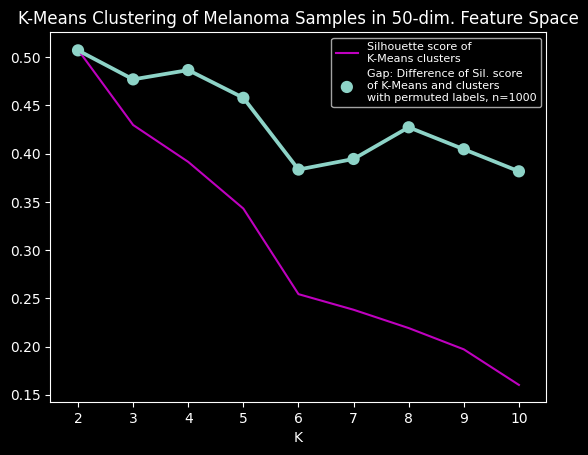

In [96]:
plt.clf()
plt.title("K-Means Clustering of Melanoma Samples in 50-dim. Feature Space")
plt.xlabel("K")
plt.plot(range(0, 9), shilouette_scores, label="Silhouette score of\nK-Means clusters", color="m")
sns.pointplot(gap_stat, label="Gap: Difference of Sil. score\nof K-Means and clusters\nwith permuted labels, n=1000")
plt.legend(fontsize="8")
plt.savefig("Gap_Statistics.pdf")

<Axes: title={'center': 'K-Means Clustering of Melanoma Samples in 50-dim. Feature Space \n Gap Statistics'}, xlabel='K', ylabel='Gap'>

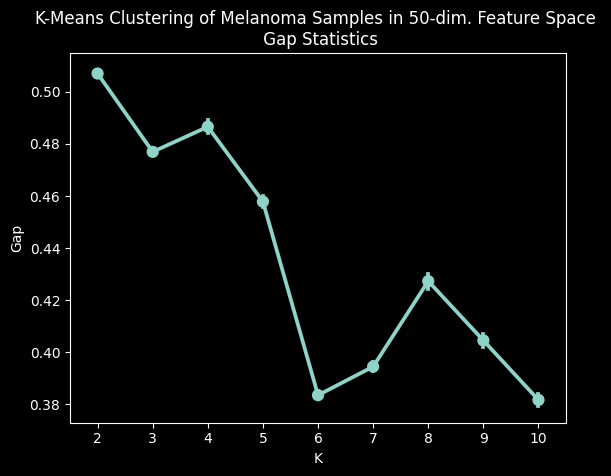

In [73]:
plt.title("K-Means Clustering of Melanoma Samples in 50-dim. Feature Space \n Gap Statistics")
plt.ylabel("Gap")
plt.xlabel("K")
sns.pointplot(gap_stat)

In [78]:
p = PCA(2)

In [79]:
transf = p.fit_transform(features)
kmeans = KMeans(n_clusters=4, n_init="auto")
y = kmeans.fit_predict(features)

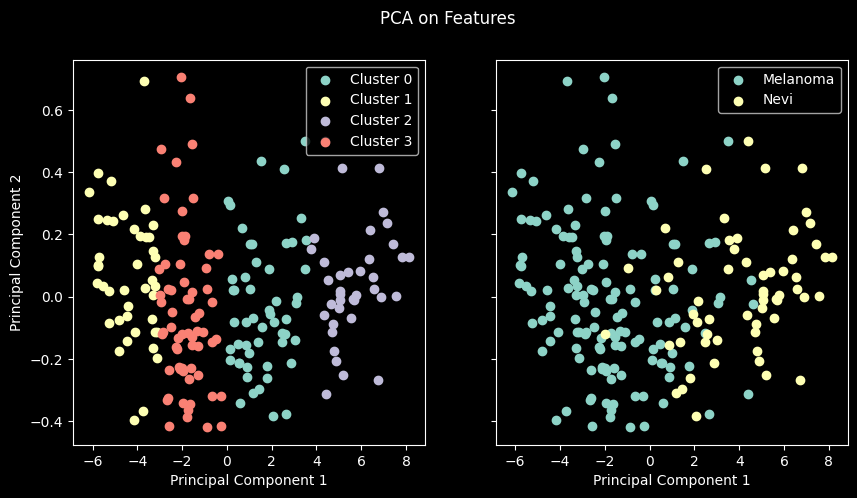

In [93]:
f, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
for c in np.unique(y):
    axs[0].scatter(transf[np.where(y == c)][:,0], transf[np.where(y == c)][:,1], label=f"Cluster {c}")
axs[0].legend()
plt.suptitle("PCA on Features")
axs[0].set_xlabel("Principal Component 1")
axs[0].set_ylabel("Principal Component 2")
axs[1].set_xlabel("Principal Component 1")


axs[1].scatter(transf[np.where(labels == 0)][:,0], transf[np.where(labels == 0)][:,1], label=f"Melanoma")
axs[1].scatter(transf[np.where(labels == 1)][:,0], transf[np.where(labels == 1)][:,1], label=f"Nevi")
axs[1].legend()

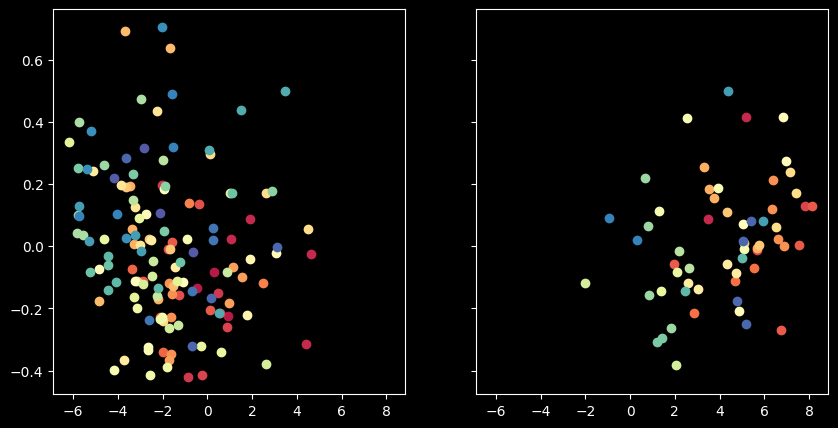

In [117]:
f, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
pal = sns.color_palette("Spectral", 42)
ids = np.array(["_".join(os.path.basename(id).split("_")[:2]) for id in data])
for i, c in enumerate(np.unique(ids)):
    if "Melanoma" in c:
        axs[0].scatter(transf[np.where(ids == c)][:,0], transf[np.where(ids == c)][:,1], label=c, color=pal[int(c.split("_")[-1])])
    else:
        axs[1].scatter(transf[np.where(ids == c)][:,0], transf[np.where(ids == c)][:,1], label=c, color=pal[int(c.split("_")[-1])*2])

In [102]:
np.where(ids == c)

(array([], dtype=int64),)

[(0.6703575547866205, 0.0602076124567474, 0.27081891580161477),
 (0.7211072664359862, 0.11649365628604381, 0.28281430219146486),
 (0.7718569780853518, 0.17277970011534027, 0.2948096885813149),
 (0.8226066897347175, 0.22906574394463664, 0.30680507497116494),
 (0.8567474048442907, 0.2756632064590542, 0.30149942329873125),
 (0.8853517877739331, 0.3190311418685121, 0.29042675893886966),
 (0.9139561707035756, 0.36239907727797, 0.27935409457900806),
 (0.942560553633218, 0.4057670126874279, 0.2682814302191465),
 (0.9610149942329873, 0.45743944636678197, 0.2765859284890427),
 (0.9693194925028835, 0.5174163783160323, 0.30426758938869664),
 (0.9790080738177624, 0.5873894655901576, 0.3365628604382929),
 (0.9873125720876587, 0.6473663975394078, 0.3642445213379469),
 (0.9925413302575933, 0.7015763168012302, 0.39653979238754317),
 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587),
 (0.9943867743175702, 0.7938485198000769, 0.47404844290657433),
 (0.9953094963475586, 0.8399846212995001, 0.5128027681660899),
 (0.9962322183775472, 0.88319876970396, 0.5530949634755863),
 (0.9971549404075356, 0.9118031526336025, 0.6010765090349866),
 (0.998077662437524, 0.9404075355632449, 0.6490580545943867),
 (0.9990003844675125, 0.9690119184928874, 0.697039600153787),
 (0.998077662437524, 0.9992310649750096, 0.7460207612456747),
 (0.9750096116878124, 0.9900038446751249, 0.7100346020761246),
 (0.9519415609381008, 0.9807766243752404, 0.6740484429065745),
 (0.9288735101883892, 0.9715494040753557, 0.6380622837370243),
 (0.9058054594386775, 0.9623221837754711, 0.6020761245674742),
 (0.8565936178392929, 0.942329873125721, 0.6053056516724337),
 (0.8021530180699736, 0.920184544405998, 0.6163783160322952),
 (0.7477124183006538, 0.8980392156862746, 0.6274509803921569),
 (0.6932718185313343, 0.8758938869665515, 0.6385236447520184),
 (0.6334486735870821, 0.8521337946943485, 0.6436755094194541),
 (0.5697808535178779, 0.8272202998846598, 0.6445982314494426),
 (0.4955017301038063, 0.7981545559400232, 0.6456747404844291),
 (0.43183391003460214, 0.7732410611303344, 0.6465974625144175),
 (0.3760092272202999, 0.7340253748558246, 0.6581314878892733),
 (0.3280276816608997, 0.6805074971164936, 0.6802768166089965),
 (0.2800461361014994, 0.6269896193771626, 0.7024221453287197),
 (0.23206459054209921, 0.5734717416378317, 0.7245674740484429),
 (0.20622837370242214, 0.5201845444059977, 0.7349480968858132),
 (0.24682814302191466, 0.4675893886966551, 0.7100346020761246),
 (0.2874279123414072, 0.4149942329873126, 0.6851211072664359),
 (0.3280276816608997, 0.36239907727797005, 0.6602076124567474)]